# Рынок заведений общественного питания Москвы

# Описание проекта

К открытию готовится небольшое кафе в Москве. 

Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами нам необходимо обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможет ли кафе снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?

Необходимо подготовить исследование рынка. В исследовании воспользуемся открытыми данными о заведениях общественного питания в Москве.

Описание данных

Таблица `rest_data:`

- `id` — идентификатор объекта;
- `object_name` — название объекта общественного питания;
- `chain` — сетевой ресторан;
- `object_type` — тип объекта общественного питания;
- `address` — адрес;
- `number` — количество посадочных мест.

## Загрузка библиотек и обзор данных. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from plotly import graph_objects as go
import plotly.express as px
import plotly.io as pio
from scipy.stats import norm
import scipy.stats 
from scipy import stats as st
import math
from io import BytesIO
from pymystem3 import Mystem
import requests
import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    rest = pd.read_csv('/datasets/rest_data.csv')
except:
    rest = pd.read_csv('/Users/irina/Documents/praktikum/csv/rest_data.csv')

In [3]:
rest[:5]

id             object_name chain object_type  \
0  151635                 СМЕТАНА   нет        кафе   
1   77874                  Родник   нет        кафе   
2   24309         Кафе «Академия»   нет        кафе   
3   21894              ПИЦЦЕТОРИЯ    да        кафе   
4  119365  Кафе «Вишневая метель»   нет        кафе   

                                             address  number  
0         город Москва, улица Егора Абакумова, дом 9      48  
1  город Москва, улица Талалихина, дом 2/1, корпус 1      35  
2          город Москва, Абельмановская улица, дом 6      95  
3            город Москва, Абрамцевская улица, дом 1      40  
4  город Москва, Абрамцевская улица, дом 9, корпус 1      50

In [4]:
rest.info()
rest.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64

In [5]:
rest.duplicated().sum()

0

В датафрейме `rest` 6 колонок, 2 типа данных object и int64, подходящих по свойствам для расчетов. Пропусков данных нет. Дубликатов нет. На этом знакомство с данными завершено. 

## Предобработка данных. 

Выше мы проверили датасет на явные дубликаты - их нет. Но так как в нашем дататсете много разных названий заведений, мы можем упростить себе задачу, сделав замены часто встречающихся 'ё' на 'е', разных видов кавычек, и приведем все названия к нижнему регистру:

In [6]:
rest['object_name'] = rest['object_name'].str.replace('ё','е')
rest['address'] = rest['address'].str.replace('ё','е')

symbols = [',', '«', '»', '(', ')', '"', '  ', '-']
for s in symbols:
    rest['object_name'] = rest['object_name'].str.replace(s, ' ')
    
rest['object_name'] = rest['object_name'].str.lower()
rest['object_type'] = rest['object_type'].str.lower()
rest['address'] = rest['address'].str.lower()

In [7]:
rest[rest.duplicated(['object_name', 'object_type', 'address'])][:10]

id                           object_name chain object_type  \
115    28614  комбинат питания мгту им.н.э.баумана   нет       буфет   
580   149205                  общественное питание   нет        кафе   
581   149131                  общественное питание   нет        кафе   
1409  151267                              альфорно   нет        кафе   
2375   28604  комбинат питания мгту им.н.э.баумана   нет    столовая   
2379   28609  комбинат питания мгту им.н.э.баумана   нет       буфет   
2380   28610  комбинат питания мгту им.н.э.баумана   нет    столовая   
2381   28611  комбинат питания мгту им.н.э.баумана   нет    столовая   
2382   28615  комбинат питания мгту им.н.э.баумана   нет    столовая   
2383   28616  комбинат питания мгту им.н.э.баумана   нет  закусочная   

                                                address  number  
115        город москва, бригадирский переулок, дом 3-5      12  
580             город москва, павелецкая площадь, дом 1      35  
581             город москва, павелецкая площадь, дом 1      39  
1409         город москва, город зеленоград, корпус 438      45  
2375  город москва, 2-я бауманская улица, дом 5, стр...     150  
2379  город москва, 2-я бауманская улица, дом 5, стр...      30  
2380  город москва, 2-я бауманская улица, дом 5, стр...     200  
2381  город москва, 2-я бауманская улица, дом 5, стр...     100  
2382  город москва, 2-я бауманская улица, дом 5, стр...     168  
2383  город москва, 2-я бауманская улица, дом 5, стр...      64

Посмотрим наличие дубликатов по названиям объектов, но будем делать поправку на то, что по одному адресу может располагаться несколько заведений общественного питания. 

In [8]:
rest.duplicated(subset=['object_name', 'address', 'chain', 'object_type', 'number']).sum()

85

Нашлось 86 дубликатов, посмотрим, какую долю от общего количества записей они составляют:

In [9]:
rest.duplicated(subset=['object_name', 'address', 'chain', 'object_type', 'number']
               ).sum() / len(rest['object_name']) * 100

0.5531693348952232

Меньше одного процента, эти дубликаты можем смело удалить:

In [10]:
rest = rest.drop_duplicates(subset=['object_name', 'address', 'chain', 'object_type', 'number']
                           ).reset_index(drop =True)

In [11]:
rest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15281 entries, 0 to 15280
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15281 non-null  int64 
 1   object_name  15281 non-null  object
 2   chain        15281 non-null  object
 3   object_type  15281 non-null  object
 4   address      15281 non-null  object
 5   number       15281 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 716.4+ KB


Посмотрим уникальность id заведений:

In [12]:
rest['id'].value_counts().to_frame()

id
151635   1
183523   1
171671   1
172634   1
169676   1
...     ..
28465    1
27946    1
29519    1
28467    1
222535   1

[15281 rows x 1 columns]

In [13]:
rest['id'].duplicated().sum()

0

Все id заведений уникальны. Теперь проверим, сколько уникальных названий заведений есть в нашем датасете:

In [14]:
rest['object_name'].value_counts().to_frame()

object_name
столовая                         321
кафе                             263
шаурма                           241
шоколадница                      158
kfc                              155
...                              ...
8 ой троллейбусный парк            1
кафе свой круг                     1
вилладжио                          1
ст.шк.1086 школьник юз             1
кальянная мята lounge              1

[9852 rows x 1 columns]

In [15]:
print('Уникальных названий в датасете:', rest['object_name'].value_counts().count())

Уникальных названий в датасете: 9852


В нашем датасете 9852 уникальных названий, вероятнее всего есть сетевые заведения, расположенные по нескольким адресам. 

In [16]:
rest['address'].value_counts().to_frame()

address
город москва, ходынский бульвар, дом 4                   95
город москва, пресненская набережная, дом 2              63
город москва, проспект мира, дом 211, корпус 2           60
город москва, кировоградская улица, дом 13а              52
город москва, площадь киевского вокзала, дом 2           47
...                                                     ...
город москва, большая переяславская улица, дом ...        1
город москва, проспект мира, дом 87                       1
город москва, новомосковская улица, дом 15а, ст...        1
город москва, улица кондратюка, дом 5                     1
город москва, улица новый арбат, дом 13                   1

[9108 rows x 1 columns]

В нашем датасете 9108 уникальных адресов, вероятнее всего есть адреса, по которым расположено несколько заведений, либо фуд-корты в торговых центрах. 

Посмотрим информацию о количестве посадочных мест:

In [17]:
rest['number'].describe().to_frame()

number
count  15281.000000
mean      59.788234
std       74.843042
min        0.000000
25%       14.000000
50%       40.000000
75%       80.000000
max     1700.000000

В среднем согласно таблице 60 мест, есть заведения вообще без посадочных мест, также есть заведение с достаточно большим количеством мест - 1700. Стоит обратить на это внимание, возможно, заведение находится в фуд-корте и количество мест указано именно относительно всей площади фуд-корта. 

## Исследовательский анализ данных.

Что нам предстоит сделать и на какие вопросы ответить: 

- Исследовать соотношение видов объектов общественного питания по количеству. Построить график.
- Исследовать соотношение сетевых и несетевых заведений по количеству. Построить график.
- Для какого вида объекта общественного питания характерно сетевое распространение?
- Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?
- Для каждого вида объекта общественного питания опишем среднее количество посадочных мест. Посмотрим, какой вид предоставляет в среднем самое большое количество посадочных мест? Построим графики.
- Выделим в отдельный столбец информацию об улице из столбца address .
- Построим график топ-10 улиц по количеству объектов общественного питания. Воспользуемся внешней информацией и ответим на вопрос — в каких районах Москвы находятся эти улицы?
- Найдём число улиц с одним объектом общественного питания. Воспользуемся внешней информацией и ответим на вопрос — в каких районах Москвы находятся эти улицы?

### Исследование соотношения видов объектов общественного питания по количеству. Построение графика.

Посмотрим, какие виды объектов общественного питания представлены в нашем датасете:

In [18]:
rest['object_type'].unique()

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

Все виды объектов общественного питания имеют уникальные наименования. Посчитаем долю каждого объекта от общего количества и сохраним в отдельную переменную:

In [19]:
object_types = rest.groupby('object_type', as_index=False).agg({'object_name':'count'}).sort_values(by='object_name', ascending=False)
object_types['ratio'] = (object_types['object_name']/object_types['object_name'].sum()*100).round(1).astype('str') + '%'
object_types.columns = ['object_type', 'count', 'ratio']
object_types

object_type  count  ratio
3                               кафе   6071  39.7%
8                           столовая   2584  16.9%
7                           ресторан   2282  14.9%
6  предприятие быстрого обслуживания   1897  12.4%
0                                бар    855   5.6%
1                              буфет    576   3.8%
4                          кафетерий    395   2.6%
2                         закусочная    348   2.3%
5          магазин (отдел кулинарии)    273   1.8%

На первом месте среди объектов общественного питания находятся кафе, следом столовые, рестораны и предприятия быстрого обслуживания. Построим график, отображающий доли предприятий от общего числа. 

In [20]:
fig = px.bar(object_types, y='object_type', x='count', text='ratio', width=1000, height=500,
             color_discrete_sequence =['#417de2'])
fig.update_xaxes(tickangle=35)
fig.update_layout(
    title='Соотношение видов объектов общественного питания по количеству',
    xaxis_title='Количество',
    yaxis_title='Тип объекта общественного питания')
fig.update_traces(textposition='outside')
fig.show()

На первом месте среди объектов общественного питания находятся кафе 39,7%, следом столовые 16,9%, рестораны 14,9% и фастфуд 12,4%. 

### Исследуем соотношение сетевых и несетевых заведений по количеству. Построим график.

Посмотрим соотношение сетевых и несетевых заведений в таблице:

In [21]:
chain = rest['chain'].value_counts().reset_index()
chain.columns = ['chain', 'amount']
chain['ratio'] = (chain['amount'] / chain['amount'].sum() * 100).round(2).astype('str') + '%'
chain

chain  amount  ratio
0   нет   12317  80.6%
1    да    2964  19.4%

Согласно таблице 80.6% заведений не являются сетевыми. Построим график соотношения сетевых и несетевых заведений:

In [22]:
rename = {'да': 'сетевые', 'нет': 'несетевые'}
rest['chain'] = rest['chain'].map(rename)

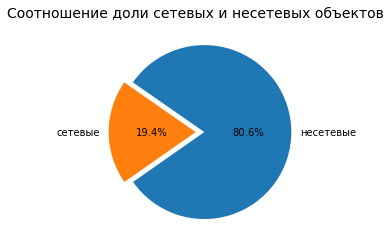

In [23]:
chain = rest.groupby('chain')['id'].count().reset_index().sort_values(by='id', ascending=False)
explode = [0.1,0]
labels = chain['chain']
fig1, ax1 = plt.subplots()
ax1.pie(chain['id'], labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=215, pctdistance=0.5, explode=explode)
plt.title('Соотношение доли сетевых и несетевых объектов', fontsize=14);

Согласно графику можно также сказать о том, что основная часть заведений общественного питания не является сетевыми. 

### Для какого вида объекта общественного питания характерно сетевое распространение?

Посмотрим, какая доля сетевых предпрятий у каждого типа объекта общественного питания:

In [24]:
object_chain = (rest
                .groupby(['object_type','chain'])['id'].count()
                .reset_index()
                .rename(columns={'id':'counts'})
                .merge(rest.groupby('object_type').chain.count(), on='object_type',suffixes=('','_total'))
               )
object_chain['ratio'] = round((object_chain.counts / object_chain.chain_total) * 100)
object_chain.sort_values(by='ratio', ascending=False)

object_type      chain  counts  chain_total  ratio
16                           столовая  несетевые    2581         2584  100.0
2                               буфет  несетевые     565          576   98.0
0                                 бар  несетевые     818          855   96.0
8                           кафетерий  несетевые     343          395   87.0
4                          закусочная  несетевые     292          348   84.0
6                                кафе  несетевые    4675         6071   77.0
14                           ресторан  несетевые    1739         2282   76.0
10          магазин (отдел кулинарии)  несетевые     195          273   71.0
12  предприятие быстрого обслуживания  несетевые    1109         1897   58.0
13  предприятие быстрого обслуживания    сетевые     788         1897   42.0
11          магазин (отдел кулинарии)    сетевые      78          273   29.0
15                           ресторан    сетевые     543         2282   24.0
7                                кафе    сетевые    1396         6071   23.0
5                          закусочная    сетевые      56          348   16.0
9                           кафетерий    сетевые      52          395   13.0
1                                 бар    сетевые      37          855    4.0
3                               буфет    сетевые      11          576    2.0
17                           столовая    сетевые       3         2584    0.0

Согласно таблице можно увидеть, что бо́льшая часть заведений по всем типам – несетевые. Столовые из нашего датасета являются на 100% несетевыми предпрятиями, буфеты и бары также практически все - авторские заведения. 

Посмотрим преобладание долей только сетевых заведений по всем типам и построим график:

In [25]:
chain_yes = object_chain.loc[object_chain.loc[:,'chain'] == "сетевые"].sort_values(by='ratio', ascending=False)
chain_yes

object_type    chain  counts  chain_total  ratio
13  предприятие быстрого обслуживания  сетевые     788         1897   42.0
11          магазин (отдел кулинарии)  сетевые      78          273   29.0
15                           ресторан  сетевые     543         2282   24.0
7                                кафе  сетевые    1396         6071   23.0
5                          закусочная  сетевые      56          348   16.0
9                           кафетерий  сетевые      52          395   13.0
1                                 бар  сетевые      37          855    4.0
3                               буфет  сетевые      11          576    2.0
17                           столовая  сетевые       3         2584    0.0

In [26]:
fig = px.bar(chain_yes.sort_values(by='ratio', ascending=False),
                y='object_type',
                x='ratio', 
               text='ratio',
                color_discrete_sequence =['#417de2']*len(chain_yes),
                title='Доли сетевых заведений от общего числа по каждому типу',
                labels={'ratio':'Доля сетевых заведений, %', 'object_type':'Тип объекта'})

fig.show()

Согласно таблице и графику самая большая доля сетевого распространения отводится фастфуду. Около 40% предприятий от общего значения предприятий быстрого обслуживания являются частью той или иной сети. Далее идут отделы кулинарии магазинов (29%), рестораны (24%) и кафе (23%). Менее всего характерно сетевое распространение для баров (4%), буфетов (2%) и 3 столовых попали в рейтинг (менее 1%).

### Проанализируем, что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

Посмотрим медианные значения количества посадочных мест и количество ресторанов:

In [27]:
avg_seats = rest[rest['chain']=='сетевые'].groupby('object_name').agg({'object_name':'count', 'number':'median'})
avg_seats.columns = ['objects', 'median_number']
avg_seats.sort_values(by='median_number', ascending=False)[:10]

objects  median_number
object_name                                      
чешская пивная козловица         1          306.0
ян примус                        1          300.0
кафе му му                       1          300.0
якитория и ян примус             1          282.0
старина миллер                   1          280.0
пражечка                         1          266.0
молли гвинз                      1          250.0
ресторан чайхана урюк            1          250.0
пилзнер                          2          245.0
бакинский бульвар                3          240.0

Согласно таблице мы можем обратить внимание на то, что большое количество посадочных мест в некоторых заведениях не является ошибкой, а вполне допустимым количеством. 

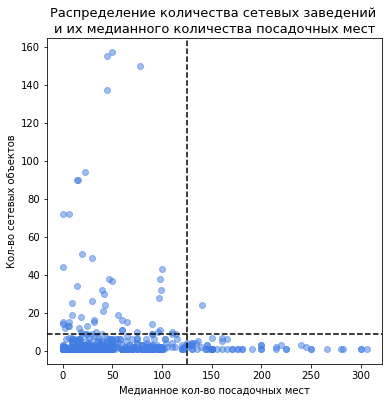

In [28]:
plt.figure(figsize=(6,6))
plt.scatter(avg_seats['median_number'], avg_seats['objects'], color='#417de2', alpha = 0.5)
plt.xlabel('Медианное кол-во посадочных мест')
plt.ylabel('Кол-во сетевых объектов')
plt.title('Распределение количества сетевых заведений \nи их медианного количества посадочных мест', fontsize=13)
plt.axhline(np.percentile(avg_seats['objects'], 90), linestyle='--', color='black')
plt.axvline(np.percentile(avg_seats['median_number'], 90), linestyle='--', color='black')
plt.show()

Согласно диаграмме преобладают сети с небольшим количеством заведений и небольшим и средним (основная масса от 0 до 50, далее по уыванию) количеством посадочных мест. Но есть и большое количество заведений, их уже будем считать выбросами. Посмотрим, что из себя представляют выбросы:

In [29]:
avg_seats.query('objects > 10').sort_values(by='objects', ascending=False)

objects  median_number
object_name                                                
шоколадница                              157           50.0
kfc                                      155           45.0
макдоналдс                               150           77.5
бургер кинг                              137           45.0
теремок                                   94           23.0
домино'с пицца                            90           16.0
крошка картошка                           90           15.0
милти                                     72            0.0
суши wok                                  72            6.0
папа джонс                                51           20.0
додо пицца                                49           30.0
кофе с собой                              44            0.0
чайхона №1                                43          100.0
хинкальная                                38           46.5
якитория                                  38           98.0
кофе хаус                                 37           50.0
subway                                    34           15.0
хлеб насущный                             32           40.0
тануки                                    32           99.0
starbucks                                 30           42.0
иль патио                                 28           97.0
прайм стар                                26           30.0
cofix                                     25           10.0
му му                                     24          140.0
мята lounge                               24           42.5
старбакс                                  21           41.0
андерсон                                  19           56.0
сабвей                                    19           10.0
пицца хат                                 18           19.0
кулинарная лавка братьев караваевых       16           31.5
кафе шоколадница                          16           60.0
пицца паоло                               15            0.0
алло пицца                                15           32.0
кофемания                                 15           65.0
сушишоп                                   15            6.0
стардогs                                  14            0.0
кружка                                    14           90.0
суши вок                                  13            6.0
суши сет                                  13            5.0
штолле                                    13           25.0
баскин роббинс                            12            2.5
волконский                                12           17.0
ваби саби                                 11           60.0
ресторан тануки                           11           98.0
кафе kfc                                  11           60.0

В лидерах выбросов крупные сети фастфуда, что объяснимо большим количеством заведений. Также можно сделать вывод, преобладают сети с небольшим количеством заведений и небольшим количеством посадочных мест.

### Для каждого вида объекта общественного питания опишем среднее количество посадочных мест. Посмотрим, какой вид предоставляет в среднем самое большое количество посадочных мест? Построим графики.

Посчитаем среднее количество посадочных мест по каждому типу заведений общепита и построим график:

In [30]:
avg_amount = rest.pivot_table(index='object_type', values='number',\
                        aggfunc= ['mean']).reset_index().sort_values(by=('mean','number'), ascending=False)
avg_amount

object_type        mean
                                          number
8                           столовая  130.337848
7                           ресторан   96.884750
1                              буфет   51.425347
0                                бар   43.533333
3                               кафе   39.785703
6  предприятие быстрого обслуживания   20.808645
4                          кафетерий    9.184810
2                         закусочная    7.847701
5          магазин (отдел кулинарии)    5.589744

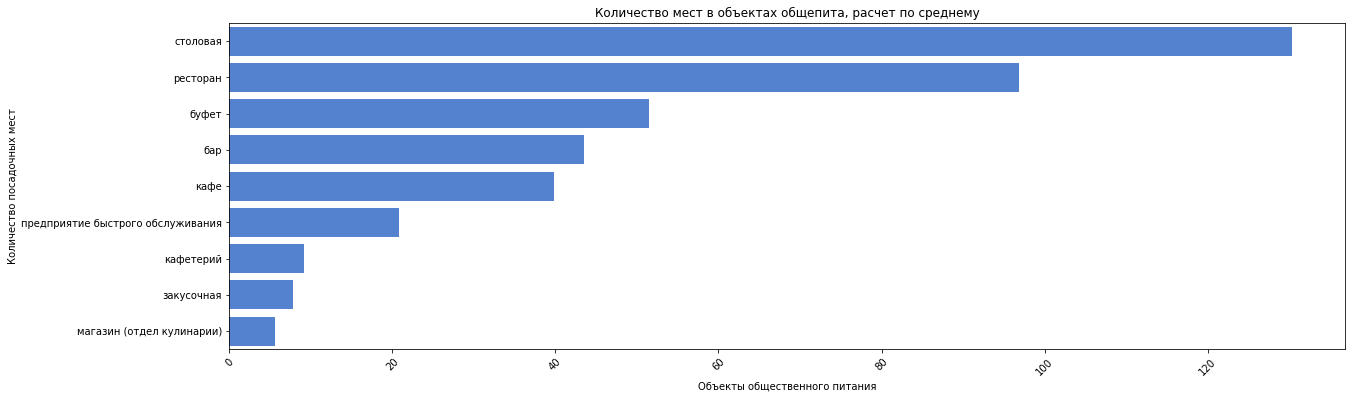

In [31]:
plt.figure(figsize=(20,6))
fig = sns.barplot(y='object_type', x=('mean','number'), 
                  data=avg_amount,
                  color='#417de2'
                 )
fig.set_xlabel('Объекты общественного питания')
fig.set_ylabel('Количество посадочных мест')
fig.set_title('Количество мест в объектах общепита, расчет по среднему')
plt.xticks(rotation=45)
plt.show()

Согласно нашей таблице и графику можно сделать вывод, что самое большое количество посадочных мест в среднем у столовых(130), ресторанов (97), буфетов (51), баров (43) и кафе (40). Посмотрим среднее количество посадочных мест по медиане, для сравнения.

In [32]:
avg_amount_median = rest.pivot_table(index='object_type', values='number',\
                        aggfunc= ['median']).reset_index().sort_values(by=('median','number'), ascending=False)
avg_amount_median

object_type median
                                     number
8                           столовая    103
7                           ресторан     80
0                                бар     35
1                              буфет     32
3                               кафе     30
4                          кафетерий      6
6  предприятие быстрого обслуживания      6
2                         закусочная      0
5          магазин (отдел кулинарии)      0

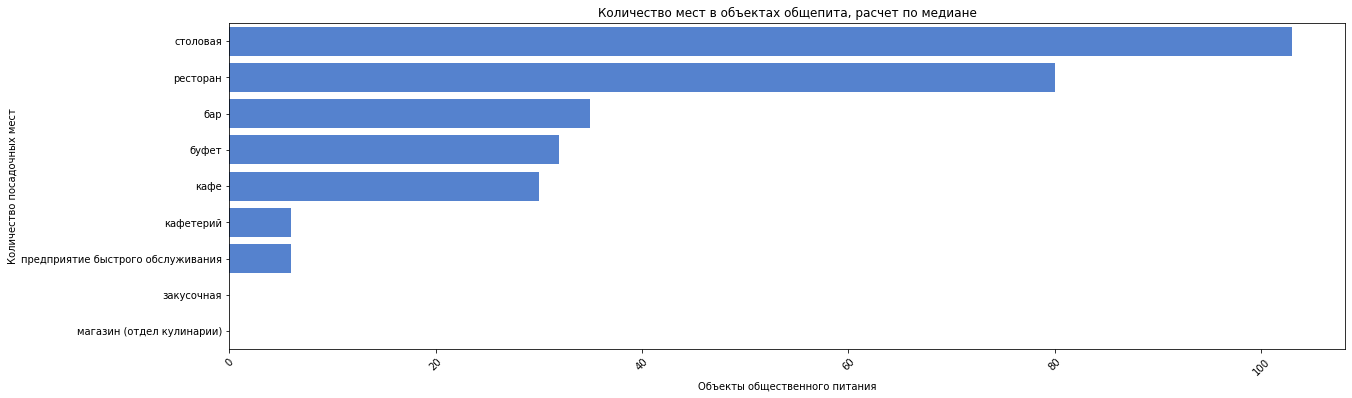

In [33]:
plt.figure(figsize=(20,6))
fig = sns.barplot(y='object_type', x=('median','number'), 
                  data=avg_amount_median,
                  color='#417de2'
                 )
fig.set_xlabel('Объекты общественного питания')
fig.set_ylabel('Количество посадочных мест')
fig.set_title('Количество мест в объектах общепита, расчет по медиане')
plt.xticks(rotation=45)
plt.show()

Если смотреть расчеты по медианным значениям, то ситуация немного отличается. Но всё так же лидируют столовые (103), рестораны (80), далее идут бары (35), буфеты (32) и только потом кафе (30).

### Выделим в отдельный столбец информацию об улице из столбца address .

Мы предварительно установили pymystem3 при загрузке всех библиотек, теперь мы можем поискать леммы слов, имеющих отношение к улицам из названий адресов (туда же относятся шоссе и т.п.):

In [34]:
m = Mystem() 
addresses = ' '.join(rest['address'].unique())
lemmas = m.lemmatize(addresses)

In [35]:
words = ['улица','ул','переулок', 'пер', 'шоссе','проспект', 'просп','площадь','проезд',
         'село','аллея','бульвар','набережная','тупик','линия', 'проспек']
str_pat = r".*,\s*\b([^,]*?(?:{})\b[^,]*)[,$]+".format("|".join(words))
rest['street'] = rest['address'].str.extract(str_pat)
rest

id            object_name      chain object_type  \
0      151635                сметана  несетевые        кафе   
1       77874                 родник  несетевые        кафе   
2       24309         кафе академия   несетевые        кафе   
3       21894             пиццетория    сетевые        кафе   
4      119365  кафе вишневая метель   несетевые        кафе   
...       ...                    ...        ...         ...   
15276  208537            шоколадница    сетевые        кафе   
15277  209264            шоколадница    сетевые        кафе   
15278  209186            шоколадница    сетевые        кафе   
15279  221900            шоколадница    сетевые        кафе   
15280  222535            шоколадница    сетевые        кафе   

                                                 address  number  \
0             город москва, улица егора абакумова, дом 9      48   
1      город москва, улица талалихина, дом 2/1, корпус 1      35   
2              город москва, абельмановская улица, дом 6      95   
3                город москва, абрамцевская улица, дом 1      40   
4      город москва, абрамцевская улица, дом 9, корпус 1      50   
...                                                  ...     ...   
15276       город москва, 3-й крутицкий переулок, дом 18      50   
15277           город москва, улица земляной вал, дом 33      10   
15278           город москва, улица земляной вал, дом 33      20   
15279  город москва, поселение московский, киевское ш...      36   
15280             город москва, ходынский бульвар, дом 4      10   

                       street  
0       улица егора абакумова  
1            улица талалихина  
2        абельмановская улица  
3          абрамцевская улица  
4          абрамцевская улица  
...                       ...  
15276  3-й крутицкий переулок  
15277      улица земляной вал  
15278      улица земляной вал  
15279          киевское шоссе  
15280       ходынский бульвар  

[15281 rows x 7 columns]

В нашем дататсете появился столбец `street` с названиями улиц.

In [36]:
(rest['street'].isna().sum())

449

Оказалось, что в нашем датасете в столбце с улицами есть 449 значений, которым не удалось присвоить названия улиц. Это может быть связано с тем, что не указан тип улицы вообще, а мы искали по возможным указаниям (улица, проспект, и т.п.), либо улица не указана вообще. Посмотрим, какую долю от всего числа в датасете составляют эти отсутствующие значения:

In [37]:
(rest['street'].isna().sum() / len(rest) * 100).round(2)

2.94

Всего 2.94% названий улиц не попали в столбец. Доля небольшая, этими пропусками данных можно пренебречь, удалять их не будем. 

### Построим график топ-10 улиц по количеству объектов общественного питания. Воспользуемся внешней информацией и ответим на вопрос — в каких районах Москвы находятся эти улицы?

Посчитаем, сколько раз повторяются улицы в адресах, и сохраним результаты в отдельную переменную, сделаем срез из первых 10 самых больших значений:

In [38]:
top_ten = rest['street'].value_counts()[:10].reset_index()
top_ten.columns = ['street', 'objects_amount']
top_ten

street  objects_amount
0           проспект мира             203
1       профсоюзная улица             181
2  ленинградский проспект             170
3  пресненская набережная             167
4        варшавское шоссе             164
5      ленинский проспект             147
6    проспект вернадского             128
7    кутузовский проспект             114
8         каширское шоссе             111
9    кировоградская улица             108

Итак, в таблице мы можем видеть топ-10 улиц, упоминаемых в датасете чаще всего. Построим график:

In [39]:
fig = px.bar(top_ten.sort_values(by='objects_amount'),
                y='street',
                x='objects_amount', 
                text='objects_amount',
                color_discrete_sequence =['#417de2']*len(top_ten),
                title='Топ-10 улиц по количеству объектов общепита',
                labels={'street':'Название улицы', 'objects_amount':'Количество объектов'})

fig.show()

Сделаем список с топ-10 улиц, чтобы потом выделить эти улицы из общего датасета:

In [40]:
top_ten_list = top_ten.groupby('street').count()
top_ten_list = top_ten_list.index[:10].to_list()
top_ten_list

['варшавское шоссе',
 'каширское шоссе',
 'кировоградская улица',
 'кутузовский проспект',
 'ленинградский проспект',
 'ленинский проспект',
 'пресненская набережная',
 'проспект вернадского',
 'проспект мира',
 'профсоюзная улица']

In [41]:
top_ten_data = rest.query('street in @top_ten_list')
top_ten_data[:10]

id                object_name      chain  \
151  155973             кафе андерсон     сетевые   
152   23618               кафе subway     сетевые   
153  155852              кафе ламаджо   несетевые   
154  152556              шаурма в пите  несетевые   
155  120658                    выпечка  несетевые   
156   26279       ресторан макдоналдс     сетевые   
165  141687           пироговая рогова  несетевые   
166  148853  кафе контдитерская кузина  несетевые   
167  149149                   суши wok    сетевые   
168  128511                      аморе  несетевые   

                           object_type  \
151                               кафе   
152                               кафе   
153                               кафе   
154  предприятие быстрого обслуживания   
155                          кафетерий   
156                               кафе   
165                               кафе   
166                               кафе   
167                               кафе   
168                               кафе   

                                              address  number  \
151             город москва, варшавское шоссе, дом 2     150   
152   город москва, варшавское шоссе, дом 7, корпус 1      36   
153            город москва, варшавское шоссе, дом 29      30   
154  город москва, варшавское шоссе, дом 72, корпус 2       0   
155           город москва, варшавское шоссе, дом 100       2   
156          город москва, варшавское шоссе, дом 143а      70   
165      город москва, проспект вернадского, дом 9/10      42   
166     город москва, проспект вернадского, дом 11/19       5   
167     город москва, проспект вернадского, дом 11/19       8   
168     город москва, проспект вернадского, дом 11/19      10   

                   street  
151      варшавское шоссе  
152      варшавское шоссе  
153      варшавское шоссе  
154      варшавское шоссе  
155      варшавское шоссе  
156      варшавское шоссе  
165  проспект вернадского  
166  проспект вернадского  
167  проспект вернадского  
168  проспект вернадского

Теперь у нас есть датасет с объектами общепита, находящимися на топ-10 найденных улицах. Теперь посмотрим, в каких районах Москвы находятся данные заведения. Для этого будем использовать найденный сторонний источник, его предварительно загрузим на Google Drive и откроем доступ. 

In [42]:
url = 'https://docs.google.com/spreadsheets/d/12z-m2PWWIzHN1x5lJafGFQFUuJJAlgqOHGVSQxi6ipU/edit?usp=sharing'
url.split('/')
id = url.split('/')[5]
top_ten_data = pd.read_csv(f'https://docs.google.com/spreadsheets/d/{id}/export?format=csv')
top_ten_data

id              object_name      chain  \
0     155973          кафе «андерсон»    Сетевое   
1      23618            кафе «subway»    Сетевое   
2     155852           кафе «ламаджо»  Несетевое   
3     152556            шаурма в пите  Несетевое   
4     120658                  выпечка  Несетевое   
...      ...                      ...        ...   
1488  213629               додо пицца    Сетевое   
1489  198436                    милти    Сетевое   
1490  222491  кальянная «мята lounge»    Сетевое   
1491  213061                     мята    Сетевое   
1492  213724              шоколадница    Сетевое   

                            object_type  \
0                                  кафе   
1                                  кафе   
2                                  кафе   
3     предприятие быстрого обслуживания   
4                             кафетерий   
...                                 ...   
1488                               кафе   
1489  предприятие быстрого обслуживания   
1490                               кафе   
1491                          кафетерий   
1492                               кафе   

                                                address  number  \
0                 город москва, варшавское шоссе, дом 2     150   
1       город москва, варшавское шоссе, дом 7, корпус 1      36   
2                город москва, варшавское шоссе, дом 29      30   
3      город москва, варшавское шоссе, дом 72, корпус 2       0   
4               город москва, варшавское шоссе, дом 100       2   
...                                                 ...     ...   
1488       город москва, пресненская набережная, дом 12      25   
1489  город москва, ленинградский проспект, дом 80, ...       0   
1490  город москва, профсоюзная улица, дом 142, корп...      40   
1491    город москва, каширское шоссе, дом 96, корпус 1      35   
1492            город москва, варшавское шоссе, дом 87б      54   

                      street                     district  location_lat  \
0           варшавское шоссе                      Donskoy     55.699949   
1           варшавское шоссе                      Donskoy     55.700888   
2           варшавское шоссе                      Donskoy     55.693228   
3           варшавское шоссе                     Nagornyy     55.656813   
4           варшавское шоссе                     Nagornyy     55.645996   
...                      ...                          ...           ...   
1488  пресненская набережная                  Presnenskiy     55.749882   
1489  ленинградский проспект                        Sokol     55.808108   
1490       профсоюзная улица                  Teplyy Stan     55.625528   
1491         каширское шоссе  Orekhovo-Borisovo Severnoye     55.614938   
1492        варшавское шоссе                     Nagornyy     55.653544   

      location_lng  
0        37.619977  
1        37.622402  
2        37.622091  
3        37.618777  
4        37.618902  
...            ...  
1488     37.537864  
1489     37.510818  
1490     37.509222  
1491     37.712319  
1492     37.620833  

[1493 rows x 10 columns]

Теперь в нашем датасете есть столбец с округами Москвы. Посмотрим, сколько всего уникальных районов было найдено в соответствии с адресами:

In [43]:
top_ten_data['district'].nunique()

37

Всего 37 разных районов и округов Москвы подходят под описания адресов. Это можно объяснить тем, что в разных округах бывают одинаковые названия улиц. Также в нашем датасете указаны координаты адресов, это тоже помогло верно определить районы местоположения.

Больше всего объектов общественного питания находится на проспекте Мира (203). Далее по количеству объектов идут Профсоюзная улица(181) и Ленинградский проспект(170). Чуть отстает по количеству объектов Пресненская набережная(167). Топ-10 - это в большинстве своем самые длинные улицы, а центральные, которые обычно сильно загружены.

С помощью внешней информации определено, в каких районах Москвы находятся эти улицы. Получили 37 районов, в которых находятся топ-10 улиц по количеству объектов общественного питания.

Больше всего заведений оказалось в Пресненском районе (167). Он расположен в Центральном административном округе, в северо-западной его части. На территории района находятся крупные деловые и торговые комплексы.

В районе Чертаново Центральное находится 90 заведений из списка. Он расположен в Южном административном округе.

Далее следует район Тропарево-Никулино (84 объекта), расположенный на территории Западного административного округа.

Обнаружено, что распределение по районам связано с протяженностью улиц. Восточный административный округ оказался обделен улицами с больщим количеством объектов питания - возможно, улицы там не такие длинные, как в других округах. Замечено много объектов в

Центральном административном округе (Пресненский район, Мещанский), Южном административном округе (Нагорный район, Чертаново Южное, Донской), Юго-Западном административном округе (Обручевский, Черемушки, Теплый Стан, Гагаринский), Западном административном округе (Тропарево-Никулино, Дорогомилово, Фили-Давыдково, Раменки), Северном (Хорошевский, Беговой район, Войковский, Аэропорт, Сокол) Северо-Восточном административном округе (Свиблово, Алексеевский).

Построим тепловую карту по координатам объектов для бо́льшей наглядности ситуации по адресам:

In [44]:
spreadsheet_id = '1YGZ6a6kvrnol3IfX2jrE4icDw9XtE4QQzzuvjmmmYT4'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
mapp = pd.read_csv(BytesIO(r.content))

fig = go.Figure(go.Densitymapbox(lon=mapp.location_lng, lat=mapp.location_lat,
                                 radius=11))

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [45]:
fig = px.bar(top_ten_data.groupby('district').count().reset_index().sort_values(by='id', ascending=False),
                y='id',
                x='district',
                text='id',
                color_discrete_sequence =['#417de2']*len(top_ten_data.groupby('district').count().reset_index().sort_values(by='id', ascending=False)),
                title='Количество заведений общепита топ-10 улиц по районам',
                labels={'district':'Район/округ', 'id':'Количество заведений'}
               )
fig.update_xaxes(tickangle=45)
fig.show()

Согласно данным бесспорный лидер – Пресненский район, там 167 заведений общественного питания на топ-10 выделенных улицах. Далее идет Чертаново-Центральное (90) и Тропарево-Никулино (84). Ниже весь список районов:

In [46]:
top_ten_data['district'].unique()

array(['Donskoy', 'Nagornyy', 'Chertanovo Yuzhnoye', 'Gagarinskiy',
       'Lomonosovskiy', 'Prospekt Vernadskogo', 'Troparevo-Nikulino',
       'Fili-Davydkovo', 'Nagatino-Sadovniki', "Moskvorech'ye-Saburovo",
       "Chertanovo Tsentral'noye", 'Dorogomilovo', 'Begovoy', 'Aeroport',
       'Sokol', 'Yakimanka', 'Obruchevskiy', 'Meshchanskiy',
       'Ostankinskiy', 'Alekseyevskiy', 'Akademicheskiy', 'Cheremushki',
       "Kon'kovo", 'Teplyy Stan', 'Ramenki', 'Orekhovo-Borisovo Yuzhnoye',
       'Chertanovo Severnoye', 'Khoroshevskiy',
       'Orekhovo-Borisovo Severnoye', 'Rostokino', 'Sviblovo', 'Yasenevo',
       'Yuzhnoye Butovo', 'Presnenskiy', 'Biryulevo Zapadnoye',
       'Shcherbinka', 'Yaroslavskiy'], dtype=object)

### Найдём число улиц с одним объектом общественного питания. Воспользуемся внешней информацией и ответим на вопрос — в каких районах Москвы находятся эти улицы?

Сгруппируем улицы, на которых есть всего лишь одно заведение общепита, сохраним в список, чтобы применить список ко всему датасету:

In [47]:
alone = rest.groupby('street').count().sort_values(by='id', ascending=True)
alone_list = alone[alone['id'] == 1].index.to_list()
len(alone_list)

549

Всего 549 улиц, где одиноко стоят по одному заведению общественного питания. Применим список ко всему датасету, чтобы владеть более полной информацией:

In [48]:
all_alone = rest.query('street in @alone_list')
all_alone[:5]

id                        object_name      chain object_type  \
19   153644  американская лаборатория десертов  несетевые        кафе   
61    21214                           столовая  несетевые    столовая   
69    22139                             хуанхэ  несетевые    ресторан   
81    25833                        азербайджан  несетевые    ресторан   
131  150881                               вгик  несетевые    столовая   

                                             address  number  \
19     город москва, филипповский переулок, дом 15/5      20   
61             город москва, бабаевская улица, дом 3      90   
69   город москва, 1-й балтийский переулок, дом 3/25      60   
81        город москва, улица демьяна бедного, дом 4     180   
131             город москва, будайская улица, дом 3      45   

                      street  
19     филипповский переулок  
61          бабаевская улица  
69   1-й балтийский переулок  
81     улица демьяна бедного  
131          будайская улица

Теперь у нас есть датасет с объектами общепита в количестве 1 на целую улицу. Теперь посмотрим, в каких районах Москвы находятся данные заведения. Для этого будем использовать найденный сторонний источник, который мы предварительно сохранили на будущее:

In [49]:
url = 'https://docs.google.com/spreadsheets/d/1EolQeleOKYujqHZ3tKj5ROFEh5O1fTsvjhGe9ZIOmM8/edit?usp=sharing'
url.split('/')
id = url.split('/')[5]
all_alone = pd.read_csv(f'https://docs.google.com/spreadsheets/d/{id}/export?format=csv')
all_alone

id                        object_name      chain  \
0    153644  американская лаборатория десертов  Несетевое   
1     21214                           столовая  Несетевое   
2     22139                             хуанхэ  Несетевое   
3     25833                        азербайджан  Несетевое   
4    150881                               вгик  Несетевое   
..      ...                                ...        ...   
550  211368                        пацио пицца  Несетевое   
551  214324                 кадаши ( закрытый)  Несетевое   
552  223171      кондитерская «пряник.рогалик»  Несетевое   
553  213930                       горячий хлеб  Несетевое   
554  205588                            кофейня  Несетевое   

                           object_type  \
0                                 кафе   
1                             столовая   
2                             ресторан   
3                             ресторан   
4                             столовая   
..                                 ...   
550                               кафе   
551                           ресторан   
552                               кафе   
553  предприятие быстрого обслуживания   
554                          кафетерий   

                                               address  number  \
0        город москва, филипповский переулок, дом 15/5      20   
1                город москва, бабаевская улица, дом 3      90   
2      город москва, 1-й балтийский переулок, дом 3/25      60   
3           город москва, улица демьяна бедного, дом 4     180   
4                 город москва, будайская улица, дом 3      45   
..                                                 ...     ...   
550  город москва, улица линии октябрьской железной...      20   
551  город москва, 2-й кадашёвский переулок, дом 16...      15   
552  город москва, город троицк, пионерская улица, ...      20   
553  город москва, поселение десеновское, улица дми...       0   
554  город москва, поселение щаповское, улица евген...      16   

                                      street                   district  \
0                      филипповский переулок                      Arbat   
1                           бабаевская улица                 Sokol'niki   
2                    1-й балтийский переулок                   Aeroport   
3                      улица демьяна бедного        Khoroshevo-Mnevniki   
4                            будайская улица                  Rostokino   
..                                       ...                        ...   
550  улица линии октябрьской железной дороги             Timiryazevskiy   
551                 2-й кадашёвский переулок                  Yakimanka   
552                         пионерская улица                    Troitsk   
553                  улица дмитрия рябинкина   Desenovskoye, Poseleniye   
554                  улица евгения родионова  Shchapovskoye, Poseleniye   

     location_lat  location_lng  
0       55.750636     37.598370  
1       55.790725     37.688995  
2       55.810465     37.518729  
3       55.769880     37.486934  
4       55.832015     37.665194  
..            ...           ...  
550     55.838810     37.572088  
551     55.743794     37.621970  
552     55.475975     37.305527  
553     55.502440     37.332568  
554     55.380702     37.402330  

[555 rows x 10 columns]

Посмотрим, сколько округов имеет по одному заведению на улицу:

In [50]:
all_alone['district'].nunique()

115

115 разных районов и округов Москвы подходят под описания адресов с одним заведением на улицу. Посмотрим график:

In [51]:
fig = px.bar(all_alone.groupby('district').count().reset_index().sort_values(by='id', ascending=False),
                y='id',
                x='district',
                text='id',
                color_discrete_sequence =['#417de2']*len(all_alone.groupby('district').count().reset_index().sort_values(by='id', ascending=False)),
                title='Количество улиц с одним заведением по районам',
                labels={'district':'Район/округ', 'id':'Количество заведений'}
               )
fig.update_xaxes(tickangle=90)
fig.show()

Обнаружилось достаточно много районов, в которых на улицах расположено по одному заведению. Таких улиц по районам: в топе Таганский (28), Хамовники (26), Басманный (22), Тверской (21). Ниже весь список районов:

In [52]:
all_alone['district'].unique()

array(['Arbat', "Sokol'niki", 'Aeroport', 'Khoroshevo-Mnevniki',
       'Rostokino', 'Meshchanskiy', 'Begovoy', 'Khamovniki', 'Tverskoy',
       "Mar'ina Roshcha", 'Mozhayskiy', 'Bogorodskoye',
       'Preobrazhenskoye', 'Dorogomilovo', 'Sokolinaya Gora', 'Basmannyy',
       'Kuntsevo', 'Lefortovo', 'Savelovskiy', 'Donskoy', 'Kotlovka',
       "Zamoskvorech'ye", "Gol'yanovo", 'Fili-Davydkovo',
       'Nizhegorodskiy', 'Ramenki', 'Lyublino', 'Sviblovo', 'Taganskiy',
       "Krasnosel'skiy", 'Yuzhnoye Butovo', 'Yakimanka', 'Ryazanskiy',
       'Pokrovskoye-Streshnevo', 'Novofedorovskoye, Poseleniye',
       'Desenovskoye, Poseleniye', 'Shcherbinka',
       'Klenovskoye, Poseleniye', 'Golovinskiy', 'Losinoostrovskiy',
       'Ostankinskiy', 'Koptevo', 'Presnenskiy', 'Kosino-Ukhtomskiy',
       'Ivanovskoye', 'Butyrskiy', 'Metrogorodok', 'Shchukino', 'Vnukovo',
       'Chertanovo Yuzhnoye', 'Yasenevo', 'Zyuzino', "Altuf'yevskiy",
       'Timiryazevskiy', 'Dmitrovskiy', 'Beskudnikovskiy', '

## Общий вывод и рекомендации о виде заведения, количестве посадочных мест, а также районе расположения. Прокомментируем возможность развития сети.

В исследовании были использованы открытые данные о заведениях общественного питания в Москве.

Исследовано соотношение видов объектов общепита по количеству: больше всего кафе (6071), далее идут столовые(2584), рестораны(2282) и фастфуд (1897).

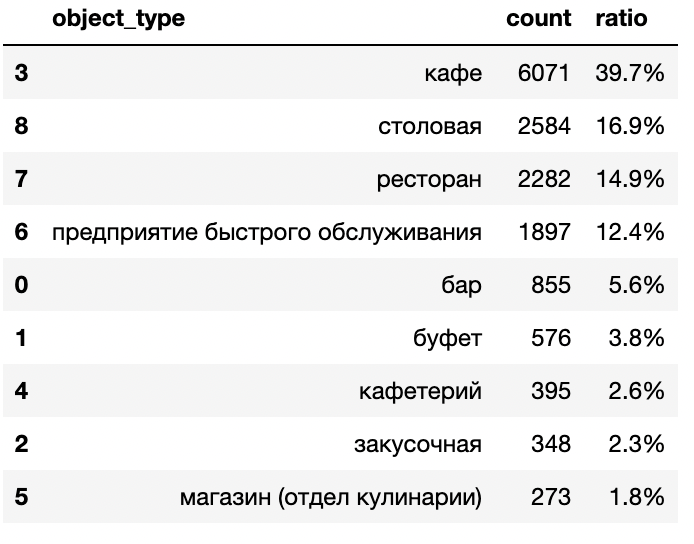

Исследовано соотношение сетевых и несетевых заведений по количеству. Лидируют несетевые объекты (12317, 80.6%), сетевых всего 2964 (19.4%).

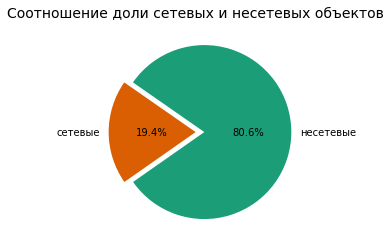


Изучено, для какого вида объекта общественного питания характерно сетевое распространение. Cамая большая доля сетевого распространения отводится фастфуду. Около 40% предприятий от общего значения предприятий быстрого обслуживания являются частью той или иной сети. Далее идут отделы кулинарии магазинов (29%), рестораны (24%) и кафе (23%). Менее всего характерно сетевое распространение для баров (4%), буфетов (2%) и 3 столовых попали в рейтинг (менее 1%).

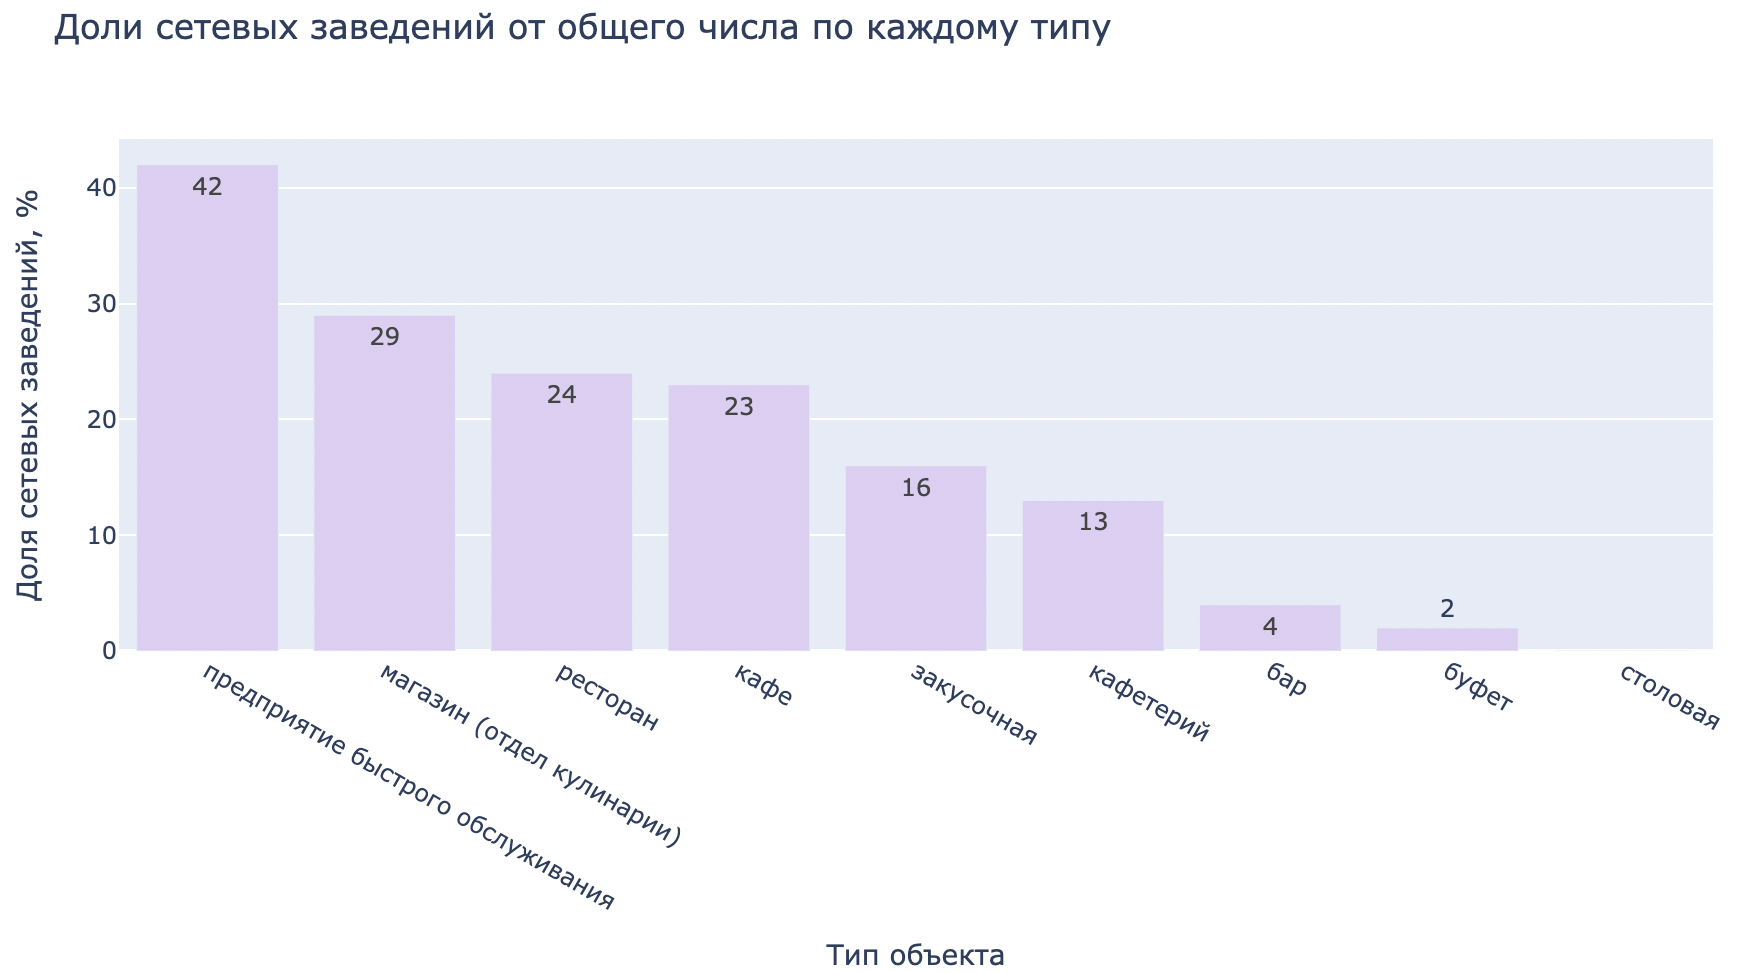


Исследовано, что характерно для сетевых заведений: в выборке преобладают сети с небольшим количеством заведений (до 10) и со средним количеством посадочных мест (до 70). Сети с большим количеством заведений обладают вместимостью от небольшой до средней (10-70 мест). Если смотреть расчеты по медианным значениям, то ситуация немного отличается. Но всё так же лидируют столовые (103), рестораны (80), далее идут бары (35), буфеты (32) и только потом кафе (30).

Выделена в отдельный столбец информация об улице из столбца address.
Для этого были использованы лемматизация и регулярные выражения.

Построен график топ-10 улиц по количеству объектов общественного питания.

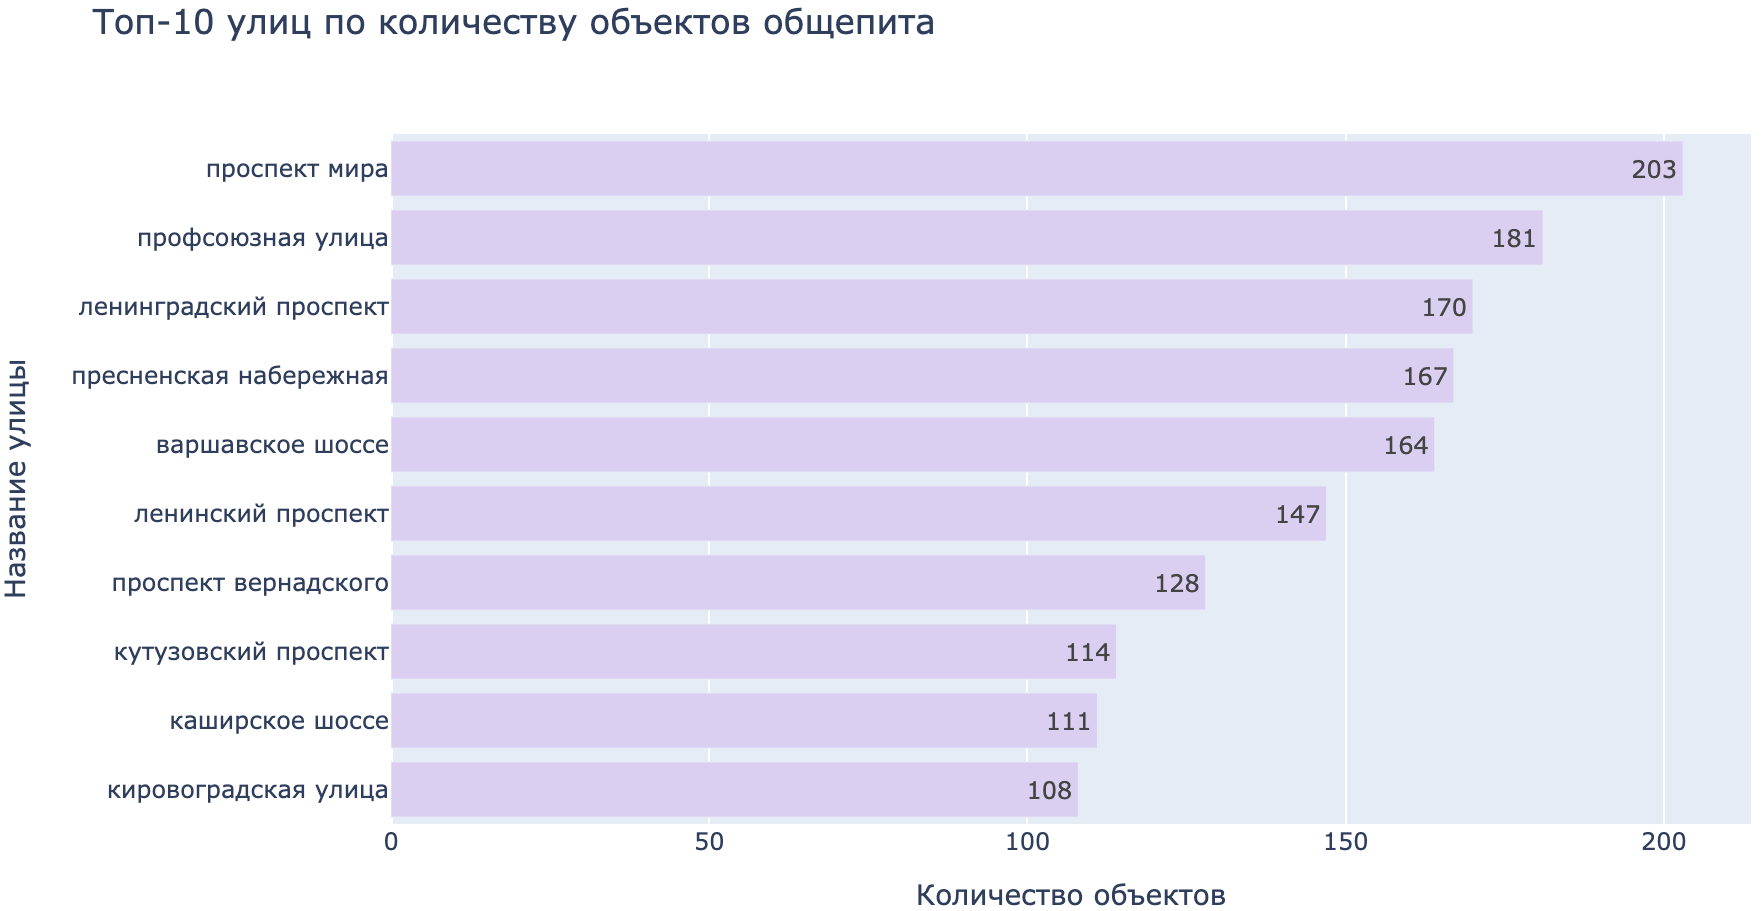

Больше всего объектов общественного питания находится на проспекте Мира (203). Далее по количеству объектов идут Профсоюзная улица(181) и Ленинградский проспект(170). Чуть отстает по количеству объектов Пресненская набережная(167). 

С помощью внешней информации определено, в каких районах Москвы находятся эти улицы. Получили 37 районов, в которых находятся топ-10 улиц по количеству объектов общественного питания.

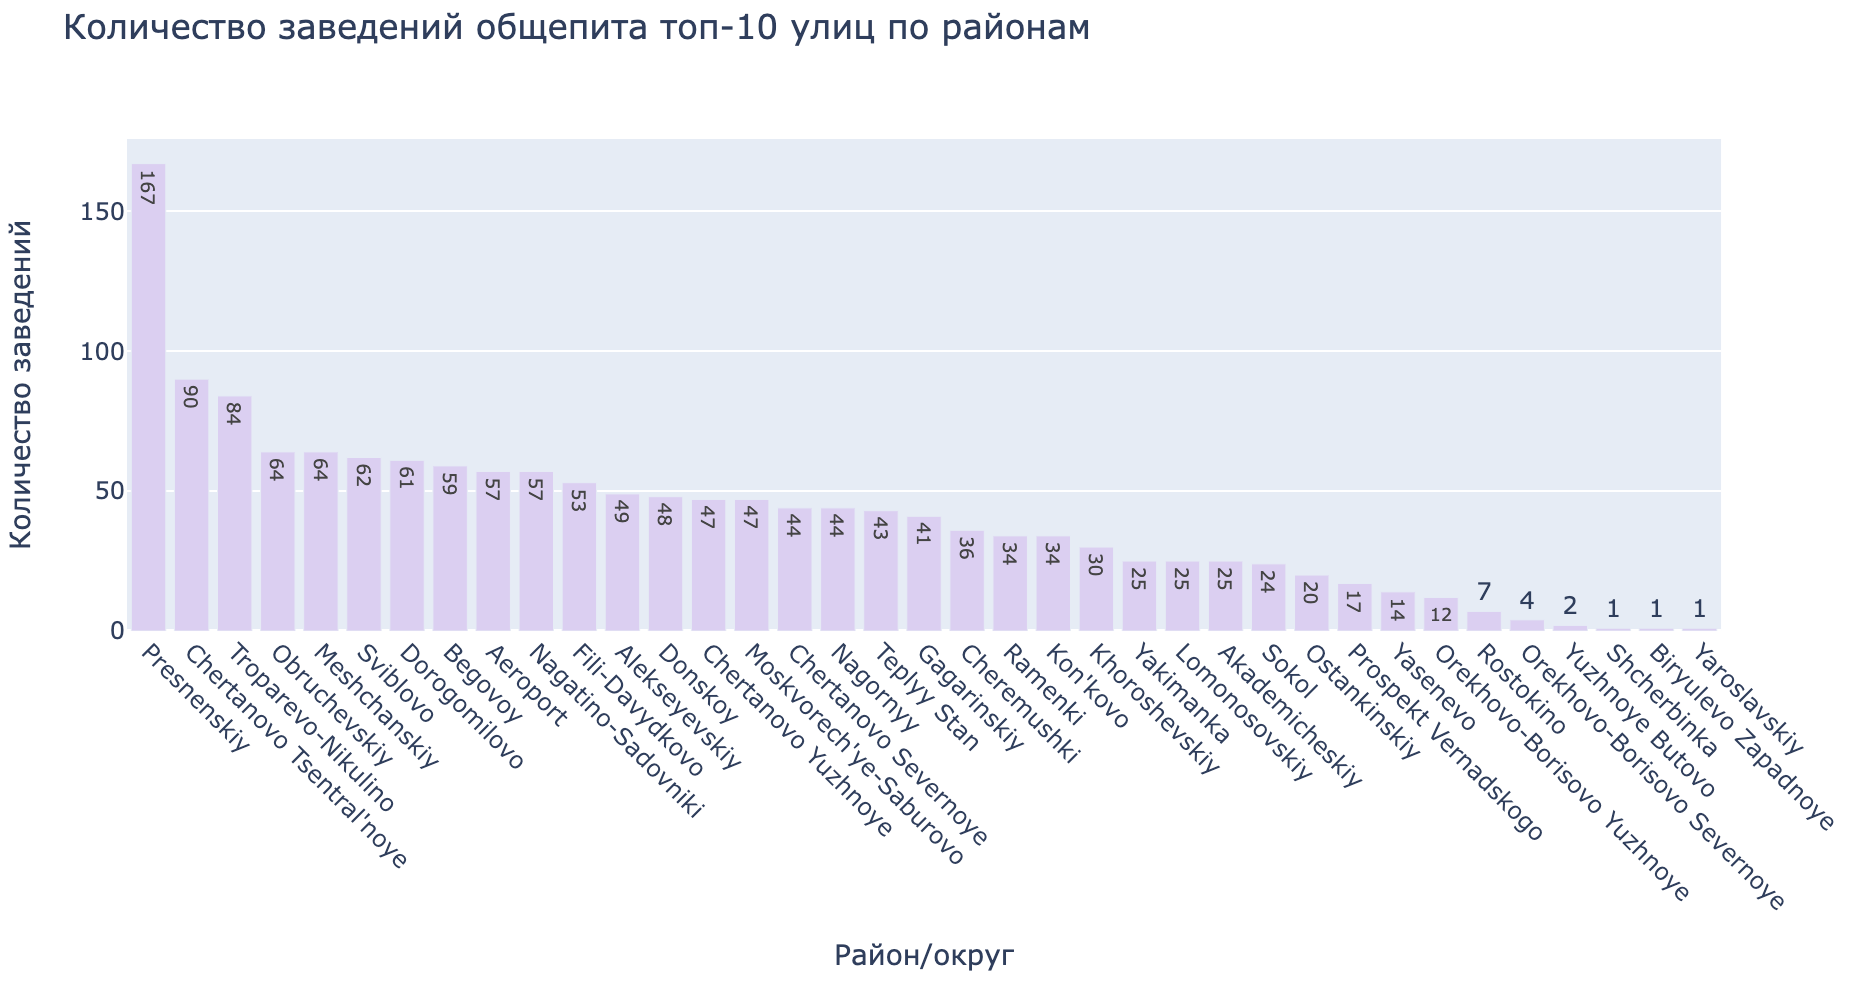

Больше всего заведений оказалось в Пресненском районе (167). Он расположен в Центральном административном округе, в северо-западной его части. На территории района находятся крупные деловые и торговые комплексы.

В районе Чертаново Центральное находится 90 заведений из списка. Он расположен в Южном административном округе.

Далее следует район Тропарево-Никулино (84 объекта), расположенный на территории Западного административного округа.

Обнаружено, что распределение по районам связано с протяженностью улиц. Восточный административный округ оказался обделен улицами с больщим количеством объектов питания - возможно, улицы там не такие длинные, как в других округах. Замечено много объектов в

- Центральном административном округе (Пресненский район, Мещанский),
- Южном административном округе (Нагорный район, Чертаново Южное, Донской),
- Юго-Западном административном округе (Обручевский, Черемушки, Теплый Стан, Гагаринский),
- Западном административном округе (Тропарево-Никулино, Дорогомилово, Фили-Давыдково, Раменки),
- Северном (Хорошевский, Беговой район, Войковский, Аэропорт, Сокол)
- Северо-Восточном административном округе (Свиблово, Алексеевский).

Найдено число улиц с одним объектом общественного питания. С помощью внешней информации определено, в каких районах Москвы находятся эти улицы. Всего 549 улиц, где одиноко стоят по одному заведению общественного питания.

**Если обратить внимание на количество районов, в которых чаще всего расположены улицы из двух составленных списков (топ-10 и улиц с одним заведением соответственно), то можно будет проанализировать, а не повлияла ли длина улицы на количество заведений. И если окажется так, что в топ-10 улицы чаще длинные (находятся в нескольких районах), а улицы из списка с одним заведением короткие - то вероятнее всего, что улицы из топ-10 на самом деле не популярнее улиц с заведениями-одиночками, а просто длиннее, и за счет этого суммарное количество заведений набирается бо́льшим, хотя если рассматривать плотность заведений на этих улицах, она не будет большой.**

**Отдельно стоит отметить тот факт, что в рамках этого исследования невозможно дать каких-либо точных рекомендаций, рекомендуется провести дополнительные исследования с анализом местоположения по районам, учитывая координаты, с учетом плотности расположения заведений на карте, близости от метро и т.д.** 

С учетом изученной информации и имеющихся данных получен **предварительный** портрет потенциально успешного предприятия общепита:

Вид заведения - кафе, несетевой объект. Это в момент открытия подчеркнет его уникальность. Количество посадочных мест - 30-40. Это среднее число подадочных мест для объектов этого типа по городу.

Район расположения - Таганский. Он расположен в Центральном административном округе, там много деловых центров, большой поток людей, хорошая транспортная доступность. Также в Таганском районе больше всего улиц с одним объектом общественного питания (28), что позволит при меньшей конкуренции претендовать на хорошую посещаемость, также проще найти хорошее помещение для аренды.

Возможность развития сети. Москва - это отличная точка старта для нового заведения с оригинальной концепцией, здесь заметен ежегодный рост туристического потока, высокая деловая и событийная активность. При положительной динамике оборота объекта общественного питания можно рассмотреть развитие концепции по системе франчайзинга. 


Источники для поиска адресов: 
https://docs.google.com/spreadsheets/d/12z-m2PWWIzHN1x5lJafGFQFUuJJAlgqOHGVSQxi6ipU/edit#gid=1596568787

https://docs.google.com/spreadsheets/d/1EolQeleOKYujqHZ3tKj5ROFEh5O1fTsvjhGe9ZIOmM8/edit#gid=1121413962

Поиск производился по индивидуальным координатам адресов, т.е. все адреса были учтены.